# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import gaussianMixtureNoiseModel
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
import os
import urllib
import zipfile
import torch
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from  https://owncloud.mpi-cbg.de/index.php/s/31ZiGfcLmJXZk3X/download and created a noise model (either GMM based or histogram based, using either the notebook ```1a_CreateNoiseModel_GMM.ipynb``` or ```1b_CreateNoiseModel_Histogram.ipynb```). Ensure that for Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif``` and not the slide edge data. For your dataset, ensure that you load the right data. 

In [2]:
path='../../../data/Mouse skull nuclei/'
# Load the training data
data=imread(path+'example2_digital_offset300.tif')
dataName='mouseskullnuclei'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
try:
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
except:
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     path, torch.Tensor(params['trained_weight']), 
                                                                     n_gaussian=int(nameNoiseModel.split('_')[-3]), 
                                                                     n_coeff=int(nameNoiseModel.split('_')[-2]))
    

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 8.615212440490723+-(2SEM)0.04277988775546037      
Epoch 1 finished      
avg. loss: 8.272030258178711+-(2SEM)0.049121391308031476      
Epoch 2 finished      
avg. loss: 8.058734655380249+-(2SEM)0.04053651231200548      
Epoch 3 finished      
avg. loss: 7.929719734191894+-(2SEM)0.04675281745537911      
Epoch 4 finished      
avg. loss: 7.857127785682678+-(2SEM)0.06560016998273299      
Epoch 5 finished      
avg. loss: 7.730397295951843+-(2SEM)0.04844095184470022      
Epoch 6 finished      
avg. loss: 7.678437066078186+-(2SEM)0.05973980066282065      
Epoch 7 finished      
avg. loss: 7.660580945014954+-(2SEM)0.05056611187470527      
Epoch 8 finished      
avg. loss: 7.606679558753967+-(2SEM)0.0774242558865929      
Epoch 9 finished      
avg. loss: 7.609955072402954+-(2SEM)0.061870594141869      
Epoch 10 finished      
avg. loss: 7.5470705270767215+-(2SEM)0.06948599048509999      
Epoch 11 finished      
avg. loss: 7.570137405395508+-(2SEM)0.061

Epoch 92 finished      
avg. loss: 7.437186288833618+-(2SEM)0.085350488598234      
Epoch 93 finished      
avg. loss: 7.374098515510559+-(2SEM)0.06716375252923804      
Epoch 94 finished      
avg. loss: 7.488733291625977+-(2SEM)0.08806605710910817      
Epoch 95 finished      
avg. loss: 7.440650820732117+-(2SEM)0.0860987776682821      
Epoch    95: reducing learning rate of group 0 to 1.5625e-05.
Epoch 96 finished      
avg. loss: 7.460162425041199+-(2SEM)0.06748798770181672      
Epoch 97 finished      
avg. loss: 7.474547028541565+-(2SEM)0.07497302791623969      
Epoch 98 finished      
avg. loss: 7.4594388723373415+-(2SEM)0.06512816099234547      
Epoch 99 finished      
avg. loss: 7.446318173408509+-(2SEM)0.06719389133733505      
Epoch 100 finished      
avg. loss: 7.453886723518371+-(2SEM)0.07453647405390713      
Epoch 101 finished      
avg. loss: 7.540065574645996+-(2SEM)0.07623264444190736      
Epoch 102 finished      
avg. loss: 7.475202822685242+-(2SEM)0.064853362935891

Epoch 181 finished      
avg. loss: 7.457970213890076+-(2SEM)0.06828155613631241      
Epoch 182 finished      
avg. loss: 7.442383599281311+-(2SEM)0.07220597753160546      
Epoch 183 finished      
avg. loss: 7.4914366722106935+-(2SEM)0.08436281112826882      
Epoch   183: reducing learning rate of group 0 to 6.1035e-08.
Epoch 184 finished      
avg. loss: 7.501375460624695+-(2SEM)0.06284891996125966      
Epoch 185 finished      
avg. loss: 7.540831279754639+-(2SEM)0.07535308450778824      
Epoch 186 finished      
avg. loss: 7.500326991081238+-(2SEM)0.08511773227336528      
Epoch 187 finished      
avg. loss: 7.4798352241516115+-(2SEM)0.06320001961848834      
Epoch 188 finished      
avg. loss: 7.492263722419739+-(2SEM)0.07412756418100494      
Epoch 189 finished      
avg. loss: 7.421827888488769+-(2SEM)0.0788920061619078      
Epoch 190 finished      
avg. loss: 7.4977768659591675+-(2SEM)0.07602250316048845      
Epoch 191 finished      
avg. loss: 7.53145215511322+-(2SEM)0.0615

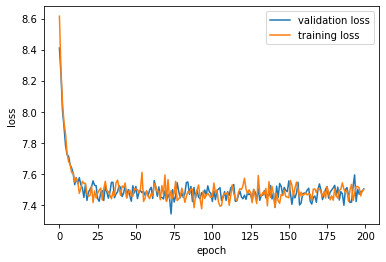

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()